In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from matplotlib import cm
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from power_to_temperature import Radio_source_trans
Cmap = cm.jet
Cmap.set_under("w")
%matplotlib inline

In [2]:
def trajectory(time,lon = -118.3011,lat = 28.9733):
    """
    Calculates trayectories for the antenna in a given time.
    Returns an array of l and b galactic coordinates values in degrees, for a given location.
    
    It is asummed that the antenna is looking derectly to the zenit, 
    so in this case the right ascention (RA) is equal to the local sideral time of the location 
    and the declination (DEC) is equal to the latitude.
    
    Parameters:
    time: local time of observation, can be an array or a single time. Prefered format is
          'yyyy-mm-dd hh:mm:ss'. 
    
    Optional parameters:
    lon: Default longitude is given for Isla de Guadalupe at -118.3011 degrees
    lat: Default latitude is given for Isla de Guadalupe at 28.9733 degrees
    """
    t = Time(time, location =(lon,lat))
    RA = np.array(t.sidereal_time('mean').degree)
    DEC = lat*np.ones(len(RA))
    coords = SkyCoord(ra=RA*u.degree,dec=DEC*u.degree)
    l = coords.galactic.l.degree
    b = coords.galactic.b.degree
    return l,b

In [3]:
def pattern(time,Freq,lon = -118.3011,lat = 28.9733):
    """
    Calculates the beam pattern for the antenna at a given time.
    Returns an array of l and b galactic coordinates values in degrees of the antenna pattern, 
    for a given location and day.
    
    It also returns an array of Temperature lecture of the antenna for a given coordinate (l,b)
    
    Parameters:
    time: local time of observation, can be an array or a single time. Prefered format is
          'yyyy-mm-dd hh:mm:ss'. 
    Freq: Frequency of the antenna beam in MHz.
    
    Optional parameters:
    lon: Default longitude is given for Isla de Guadalupe at -118.3011 degrees
    lat: Default latitude is given for Isla de Guadalupe at 28.9733 degrees
    """
    Data = pd.read_hdf("antenna_beam/0%dMHz.hdf5"%Freq)
    t = Time(time, location =(lon,lat))
    LST = t.sidereal_time('mean').degree
    theta,phi = np.radians(Data.values[:,0]),np.radians(Data.values[:,1])
    dB = Data.values[:,2]
    X,Y,Z=np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta) 
    Rxy = np.sqrt(X**2.+Y**2.)
    colat,Az = np.arctan2(Rxy,Z),np.arctan2(Y,X)
    Alt = 0.5*np.pi-colat
    lat = np.radians(lat)
    sinDEC = np.sin(Alt)*np.sin(lat)-np.cos(Alt)*np.cos(Az)*np.cos(lat)
    DEC = np.arcsin(sinDEC)
    sinH = np.sin(Az)*np.cos(Alt)/np.cos(DEC)
    cosH = (np.cos(Az)*np.cos(Alt)*np.sin(lat)+np.sin(Alt)*np.cos(lat))/np.cos(DEC)
    H = np.arctan2(sinH,cosH)
    DEC = np.degrees(DEC)
    RA = LST - np.degrees(H)
    coords = SkyCoord(ra=RA*u.degree,dec=DEC*u.degree)
    l = coords.galactic.l.degree
    b = coords.galactic.b.degree
    Temp = Radio_source_trans(dB,Freq,1e6)
    return l,b,Temp

In [4]:
def convolve(time,Freq):
    """
    Convolves the antenna beam pattern with the gsm map of the galaxy for a given frequenacy.
    Returns the convolved temperature of the gsm.
    
    Parameters:
    time: local time of observation, can be an array or a single time. Prefered format is
        'yyyy-mm-dd hh:mm:ss'.
    Freq: Frequency desired in MHz.
    """
    nside = 32
    Data = pd.read_hdf("gsm_maps/gsm_%dMHz.hdf5"%Freq)
    bmap_gal = Data.values[:,0]
    bmap_gal2 = hp.ud_grade(bmap_gal,nside)
    l,b,Temp = pattern(time,Freq)
    pix = hp.ang2pix(nside,l, b, lonlat=True)
    bmap_pat = np.zeros(hp.nside2npix(nside))
    bmap_pat[pix] = Temp
    T_gsm = sum(bmap_gal2*bmap_pat)/sum(bmap_pat)
    return T_gsm

In [5]:
def T_gsm(time,freqs = (50,90),bins=20,days=1):
    """
    Provides a table of the convolved temperature of the GSM map with the 
    Antenna beam pattern for a full day of observation, in a range of frequencies.
    It saves a file named Tgsm.hdf5 with the values obtained  in the calibration folder.
    
    
    Parameters:
    time: Initial date and time of observation, prefered format is 'yyyy-mm-dd hh:mm:ss'. 
    
    
    Optional parameters:
    freqs: Range of frequencies, must be a tuple with initial frequency and final frequency.
           Default is 50-90
    
    bins: Observation interval in minutes, default is 20 minutes.
    days: Days of observation, default is 1 day.
    """
    
    Freqs = np.arange(freqs[0],freqs[1]+1)
    t0 = Time(time)
    dt = bins*u.min #Cambiar segun se requiera
    DT = dt.to(u.hour)
    times = t0 + DT*np.arange(0,days*24/DT.value)
    data = np.zeros([len(Freqs),len(times)])
    i,j = 0,0
    for f in Freqs:
        for k in range(len(times)):
            data[i,j] = convolve(times[k],f)
            j+=1
        i+=1
        j=0
    df = pd.DataFrame(data,index = Freqs,columns = times.value)
    df.to_hdf('calibration/Tgsm.hdf5','df')
    return df

In [6]:
dates =  ['2018-04-03 00:00:00','2018-04-03 23:59:59']
T = Time(dates)
dt = T[1]-T[0]
times = T[0] + dt*np.linspace(0.,1.,300)

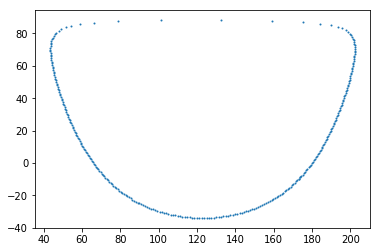

In [7]:
l_gal,b_gal = trajectory(times)
plt.plot(l_gal,b_gal,'o',markersize=1)

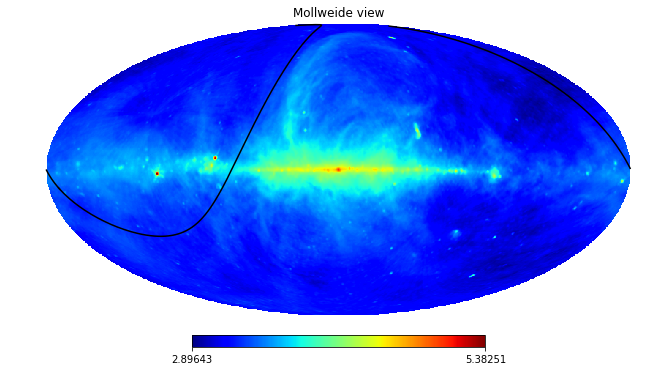

In [8]:
Data_70 = pd.read_hdf("gsm_maps/gsm_70MHz.hdf5")
bmap_gal = Data_70.values[:,0]
bmap_gal = np.log10(bmap_gal)
hp.mollview(bmap_gal,cmap=Cmap)
hp.projplot(l_gal, b_gal,'-k',lonlat=True)
plt.savefig('Imagenes/Trajectory.png')
plt.show()

In [9]:
t0 = Time('2013-06-01 00:00:00')
dt = 4*u.hour
times = t0 + dt*np.arange(0,24/dt.value)
for i in range(len(times)):
    l,b,Temp = pattern(time = times[i],Freq=70)
    nside = 32
    pix = hp.ang2pix(nside,l, b, lonlat=True)
    bmap_pat = np.zeros(hp.nside2npix(nside))
    bmap_pat[pix] = Temp
    hp.cartview(bmap_pat,cmap=Cmap)
    hp.projplot(l_gal, b_gal,'.k',lonlat=True)
    plt.savefig('Imagenes/'+str(t0+i*dt)+'_cartview_gal.png')
    plt.close()
    hp.mollview(bmap_pat,cmap=Cmap)
    hp.projplot(l_gal, b_gal,'-k',lonlat=True)
    plt.savefig('Imagenes/'+str(t0+i*dt)+'_mollview_gal.png')
    plt.close()
    hp.mollview(bmap_pat,coord =['G','C'],cmap=Cmap,flip='geo')
    plt.savefig('Imagenes/'+str(t0+i*dt)+'_mollview_altaz.png')
    plt.close()

In [10]:
#T_gsm('2013-06-14 00:00:00') #Generate data example
Data = pd.read_hdf('calibration/Tgsm.hdf5')

In [11]:
Freqs = np.arange(50,91)
for f in Freqs:
    Temp = Data.loc[f].values
    Time = (np.linspace(0,24,len(Temp))+8)%24
    plt.plot(Time,Temp,'o',markersize = 4)
    plt.xlabel('LST')
    plt.ylabel('Temperature [Kelvin]')
    plt.xlim(0,24)
    plt.grid()
    plt.savefig('Imagenes/variation_%dMHz.png'%f)
    plt.close()

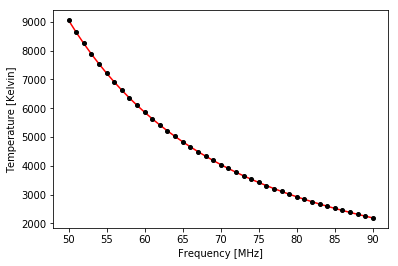

In [12]:
index = Data.index.values
column = Data.columns.values
Temp = Data['2013-06-14 10:00:00.000'].values
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')
plt.plot(Freqs,Temp,'-r')
plt.plot(Freqs,Temp,'ko', markersize=4)
plt.savefig('Imagenes/FreqvsTemp.png')
plt.show()


In [1]:
import pandas as pd

In [2]:
Data = pd.read_hdf('calibration/Tgsm.hdf5')

In [3]:
Data

,2013-06-14 00:00:00.000,2013-06-14 00:05:00.000,2013-06-14 00:10:00.000,2013-06-14 00:15:00.000,2013-06-14 00:20:00.000,2013-06-14 00:25:00.000,2013-06-14 00:30:00.000,2013-06-14 00:35:00.000,2013-06-14 00:40:00.000,2013-06-14 00:45:00.000,...,2013-06-14 23:10:00.000,2013-06-14 23:15:00.000,2013-06-14 23:20:00.000,2013-06-14 23:25:00.000,2013-06-14 23:30:00.000,2013-06-14 23:35:00.000,2013-06-14 23:40:00.000,2013-06-14 23:45:00.000,2013-06-14 23:50:00.000,2013-06-14 23:55:00.000
50,3728.819287,3709.233872,3691.083584,3675.572687,3660.656969,3647.783459,3636.744887,3627.270514,3619.213741,3613.211556,...,3975.257679,3943.311425,3912.687727,3882.769495,3853.949855,3826.979805,3801.282204,3777.144612,3754.327417,3733.491932
51,3556.319349,3537.606715,3520.264346,3505.437706,3491.180484,3478.870685,3468.311552,3459.245768,3451.534932,3445.779164,...,3791.628392,3761.135378,3731.903156,3703.341234,3675.824823,3650.070605,3625.531557,3602.478330,3580.684236,3560.781616
52,3394.769346,3376.874158,3360.288313,3346.103166,3332.462909,3320.681142,3310.571427,3301.888154,3294.501662,3288.976852,...,3619.649889,3590.518675,3562.590423,3535.299129,3509.003758,3484.388451,3460.935568,3438.897593,3418.062103,3399.034666
53,3243.291010,3226.163468,3210.287496,3196.703656,3183.642327,3172.355801,3162.668001,3154.343655,3147.261189,3141.953442,...,3458.388405,3430.535873,3403.830331,3377.731006,3352.581425,3329.034734,3306.600223,3285.515236,3265.578786,3247.371837
54,3101.093615,3084.686279,3069.477241,3056.458496,3043.940449,3033.119384,3023.827915,3015.840408,3009.043622,3003.940002,...,3307.002160,3280.349634,3254.793377,3229.814057,3205.740150,3183.196955,3161.719559,3141.528982,3122.437076,3105.001100
55,2967.459361,2951.729562,2937.147304,2924.659836,2912.652846,2902.269365,2893.350395,2885.679944,2879.152124,2874.239743,...,3164.727706,3139.203914,3114.728163,3090.801274,3067.739317,3046.140013,3025.561805,3006.212737,2987.915185,2971.203906
56,2841.737786,2826.645602,2812.653447,2800.666011,2789.140384,2779.168614,2770.600182,2763.228214,2756.953407,2752.221574,...,3030.873012,3006.411441,2982.953126,2960.017179,2937.907547,2917.196859,2897.465216,2878.908339,2861.358021,2845.328933
57,2723.338234,2708.846790,2695.410687,2683.894426,2672.821909,2663.238260,2655.000573,2647.909823,2641.873248,2637.311816,...,2904.809460,2881.349664,2858.849640,2836.847744,2815.635264,2795.761662,2776.827637,2759.017206,2742.171221,2726.784668
58,2611.723415,2597.798595,2584.886777,2573.814972,2563.170125,2553.952392,2546.026509,2539.201099,2533.389429,2528.988642,...,2785.965572,2763.450221,2741.854376,2720.733371,2700.367390,2681.283408,2663.101871,2645.995353,2629.813634,2615.033339
59,2506.402651,2493.012730,2480.595940,2469.943763,2459.702758,2450.830332,2443.198862,2436.623872,2431.024765,2426.775500,...,2673.819071,2652.195739,2631.453925,2611.164493,2591.597748,2573.259297,2555.788298,2539.346375,2523.791641,2509.584031


24